In [3]:
print("start")

start


In [80]:
import yfinance as yf
import datetime
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import coint
import statsmodels.api as sm
import torch
import torch.nn as nn
import os
import math
import warnings

In [29]:
sp500_data = pd.read_csv('SP500.csv')
print(sp500_data.head())

         Date         Open         High          Low        Close  \
0  2010-01-04  1116.560059  1133.869995  1116.560059  1132.989990   
1  2010-01-05  1132.660034  1136.630005  1129.660034  1136.520020   
2  2010-01-06  1135.709961  1139.189941  1133.949951  1137.140015   
3  2010-01-07  1136.270020  1142.459961  1131.319946  1141.689941   
4  2010-01-08  1140.520020  1145.390015  1136.219971  1144.979980   

     Adj Close      Volume  
0  1132.989990  3991400000  
1  1136.520020  2491020000  
2  1137.140015  4972660000  
3  1141.689941  5270680000  
4  1144.979980  4389590000  


In [30]:
sp500_data['Date'] = pd.to_datetime(sp500_data['Date'])  # Convert Date column to datetime
price_history = {"^GSPC": sp500_data.set_index('Date')["Close"]}  # Set Date as the index for easy lookup

In [31]:
class stock:
    def __init__(self, ticker):
        self.ticker = ticker
        self.history  = []
        self.long_position = 0
        self._long_history = np.zeros([0, 2]) #this keeps track of the amount of shares bought and at which prices. IF some shares are sold then they are removed from this list
        self.short_postion=0
        self._short_history = np.zeros([0,2]) #the opposite of long_history
        self.invested=0 #this is the amount of money invested in the stock
        self.realized_profit = 0.0 #this is accumulated profit from all transactions
        self.immediate_profit=0.0 #this is profit from the last transaction

    def _subtract_from_array(self, arr, X): #Used for removing shares from the history and calculating how much money was invested in those shares. Is useful for calculating profit of each transaction
        arr = np.array(arr, dtype=float)  # Ensure the array is a NumPy array and supports float operations
        cumulative_sum = np.cumsum(arr[:,0])  # Compute the cumulative sum of the array
        remaining = cumulative_sum - X   # Subtract X from the cumulative sum

        # print(arr,X)
        if remaining[-1]>0:
            # Find where the remaining amount becomes non-positive
            zeroed_indices = remaining <= 0
            #calculatenet money invested on the sold shares
            net_invested = arr[zeroed_indices,0].T@arr[zeroed_indices,1]
            # Update the array based on the remaining amount
            arr = arr[~zeroed_indices]
            net_invested+= (arr[0,0]-remaining[~zeroed_indices][0])*arr[0,1]
            arr[0,0] = remaining[~zeroed_indices][0]
        else:
            net_invested=arr[:,0].T@arr[:,1]
            arr=np.zeros([0, 2])
        # print(arr)
        return (arr,net_invested)
    
    def buy(self, date, amount):
        self.history.append((price_history[self.ticker][date], amount, +1))        
        shorted=min(self.short_postion, amount)
        bought=amount-shorted
        
        self.immediate_profit=0 # I reset this to 0 if no shares are shorted. So that when called from outside it tells no profit has been made or lost
        if shorted>0:
            self._short_history, net_borrowed = self._subtract_from_array(self._short_history, shorted) #remove the number of shorted shares from previous short history
            self.immediate_profit=net_borrowed - shorted * price_history[self.ticker][date]#profit from buying the shorted shares
            self.realized_profit += self.immediate_profit #accumulated profit
            self.short_postion -= shorted

        self._long_history=np.append(self._long_history,np.array([[bought,price_history[self.ticker][date]]]), axis=0) #append the new buy to the long history
        self.long_position += bought

        self.invested += amount * price_history[self.ticker][date] #shorted shares also count towards investing because they cancel out the negative sum we invested in the begining
        
    
    def sell(self, date, amount):
        self.history.append((price_history[self.ticker][date], amount, -1))
        long_sold = min(self.long_position, amount)
        shorted = amount - long_sold

        self.immediate_profit=0 # I reset this to 0 if no shares are shorted. So that when called from outside it tells no profit has been made or lost
        if long_sold > 0:
            self._long_history, net_invested = self._subtract_from_array(self._long_history, long_sold)  # Remove the number of sold shares from previous long history
            self.immediate_profit= long_sold * price_history[self.ticker][date] - net_invested  # Profit from selling the long shares
            self.realized_profit += self.immediate_profit #accumulated profit
            self.long_position -= long_sold

        self._short_history = np.append(self._short_history, np.array([[shorted, price_history[self.ticker][date]]]), axis=0)  # Append the new short to the short history
        self.short_postion += shorted

        self.invested -= amount * price_history[self.ticker][date] #invested amount can go negative if we are shorting as we are borrowing money.

    def close(self,date):
        if self.long_position > 0:
            self.sell(date, self.long_position)
        if self.short_postion > 0:  
            self.buy(date, self.short_postion)
        pass
    
    def unrealized_profit(self, date):
        # Calculate unrealized profit based on the current price and the invested amount
        current_price = price_history[self.ticker][date]
        profit = self._long_history[:,0].T@(current_price-self._long_history[:,1])
        profit += self._short_history[:,0].T@(self._short_history[:,1]-current_price)
        
        return profit

In [32]:
# Create a stock instance with a sample ticker
test_stock = stock("^GSPC")

# Define a test date and price
test_date = price_history["^GSPC"].index[0]  # Use the first date in price_history
test_price = price_history["^GSPC"][test_date]

# Perform a buy operation
test_stock.sell(test_date, 10)  # Buy 10 shares
print(test_stock.immediate_profit)

test_date2 = price_history["^GSPC"].index[1]  # Use the first date in price_history
test_stock.buy(test_date2, 5)  # Sell 5 shares
expected_profit = 5 * (price_history["^GSPC"][test_date2]-test_price)  # Expected profit from selling 5 shares
print(test_stock.immediate_profit, expected_profit)

test_date21 = price_history["^GSPC"].index[2]  # Use the first date in price_history
test_stock.sell(test_date21, 5)  # Sell 5 shares
expected_profit = 0
print(test_stock.immediate_profit, expected_profit)

test_date3 = price_history["^GSPC"].index[3]  # Use the first date in price_history
test_stock.buy(test_date3, 5)  # Sell 5 shares
expected_profit = 5 * (price_history["^GSPC"][test_date3]-test_price)  # Expected profit from selling 5 shares
print(test_stock.immediate_profit, expected_profit)

print(test_stock.realized_profit)

date5=price_history["^GSPC"].index[5]
test_stock.close(price_history["^GSPC"].index[5])
expected_profit = 5 * (price_history["^GSPC"][date5]-price_history["^GSPC"][test_date21])
print(test_stock.immediate_profit, expected_profit)

print(test_stock.realized_profit)
print("Test passed: .immediate_profit is working as expected.")


0
-17.650149999999485 17.650149999999485
0 0
-43.49975500000073 43.49975500000028
-61.14990500000022
-49.1998250000006 49.1998250000006
-110.34973000000082
Test passed: .immediate_profit is working as expected.


In [33]:
class NNQ():
    def __init__(self,state_size):
        self.model = nn.Sequential(nn.Linear(state_size, 128), nn.ReLU(), nn.Linear(128, 128), nn.ReLU(), nn.Linear(128, 3)) #neural network takes 1 input and gives 3 output. Each output is for each actions
        self.target_model = nn.Sequential(nn.Linear(state_size, 128), nn.ReLU(), nn.Linear(128, 128), nn.ReLU(), nn.Linear(128, 3))
        self.target_model.load_state_dict(self.model.state_dict())  # Copy weights from self.model
        self.target_model.eval()  # Set the target model to evaluation mode
        self.optimizers = torch.optim.Adam(self.model.parameters(), lr=0.001)
        self.loss_fn=nn.MSELoss()
        self.actions=np.array([-1, 0, 1]) #-1 is sell, 0 is hold, 1 is buy
        self.loss_table=[]
    
    def get(self,s,a):
        i=np.where(self.actions==a)[0][0]
        s_torch = torch.tensor([s], dtype=torch.float32)
        # print("action=",a," i=",i,", state=",s_torch)
        return self.model(s_torch).detach().numpy().item(i)
    
    def target(self,data,discount):
        ans=np.zeros(len(data))
        for i in range(len(data)):
            s,a,r,s_prime=data[i]
            s_torch = torch.tensor([s_prime], dtype=torch.float32)
            max_q=np.max(self.target_model(s_torch).detach().numpy())
            if s_prime is None:
                ans[i]=r
            else:
                ans[i]=r+discount*max_q
        return ans
    
    def update(self, data, epochs):
        t=self.target(data,0.9)
        self.model.train()
        for _ in range(epochs):
            i=0
            avg_loss=0  
            states = torch.tensor([s for (s, a, r, s_prime) in data], dtype=torch.float32)
            action_indices = [np.where(self.actions == a)[0][0] for (s, a, r, s_prime) in data]
            targets = torch.tensor(t, dtype=torch.float32)

            self.optimizers.zero_grad()
            predictions = self.model(states)[range(len(action_indices)), action_indices]
            loss = self.loss_fn(predictions, targets)
            loss.backward()
            self.optimizers.step()

            avg_loss = loss.item()
            self.loss_table.append(avg_loss)

        print("average loss=",avg_loss)
        pass


In [34]:
def epsilon_greedy(q,s,eps):
    if np.random.rand()<eps:
        return np.random.choice([-1,0,1])
    else:
        q_values=[q.get(s,a) for a in [-1,0,1]]
        return np.argmax(q_values)-1

In [35]:
price_return = price_history["^GSPC"].pct_change().fillna(0)*100
price_return

Date
2010-01-04    0.000000
2010-01-05    0.311568
2010-01-06    0.054552
2010-01-07    0.400120
2010-01-08    0.288173
                ...   
2019-12-24   -0.019545
2019-12-26    0.512817
2019-12-27    0.003398
2019-12-30   -0.578082
2019-12-31    0.294602
Name: Close, Length: 2516, dtype: float64

In [36]:
def sigmoid(x):
    return 1 / (1 + math.exp(-x))

def getState(stk,data, t, n):    
    d = t - n + 1
    block = data.iloc[d:t + 1].values if d >= 0 else np.concatenate((np.full(-d, data.iloc[0]), data.iloc[0:t + 1].values))  # pad with t0
    res = np.array([block[i + 1] / block[i] - 1 for i in range(n - 1)])*100 #percent changes for last n-1 days
    # res= np.array([sigmoid(block[i + 1]-block[i]) for i in range(n - 1)])
    # feature1=(stk.long_position-stk.short_postion)/ 5 #number of stocks owned normalized by 30
    # feature2=20*stk.unrealized_profit(price_return.index[t])/stk.invested if stk.invested!=0 else 0
    ans = res# np.concatenate((res, [feature1, feature2]))
    return ans
# print(getState(SP,price_history["^GSPC"],1,3))

In [37]:
Ndata=len(price_return)
#test-train split
Ntrain=int(Ndata*0.7)

In [38]:
window_size = 30
state_size = window_size + 0  # 2 for number of stocks and unrealized profit
Q = NNQ(state_size)
epochs = 20  # Define the number of epochs
capital=10000# amount of money available to invest

# Generate 1000 random samples of states
random_states = np.random.rand(1000, state_size) * 2 - 1

# Initialize a dictionary to store Q-values for each epoch
q_values_over_epochs = {action: [] for action in [-1, 0, 1]}
for action in [-1, 0, 1]:
        q_values_over_epochs[action].append(
            [Q.get(state, action) for state in random_states]
        )
for epoch in range(epochs):
    SP = stock("^GSPC")
    stock_history = []
    profit = []
    for i in range(Ntrain - 1):
        s = getState(SP,price_history["^GSPC"], i, window_size + 1)  # Get the state
        eps_decay = 0.1 + 0.9 * np.exp(-i / Ntrain * 1)  # Epsilon decay
        a = epsilon_greedy(Q, s, eps_decay)
        date = price_history["^GSPC"].index[i]
        if a == 1:
            SP.buy(date, 1) #buy the share
            date2 = price_history["^GSPC"].index[i+1]
            SP.sell(date2, 1) #sell immediately the next date.
            r = SP.immediate_profit/price_history["^GSPC"][date]*100 #percent of profit made
        elif a == -1:
            SP.sell(date, 1) #short the share
            date2 = price_history["^GSPC"].index[i+1]
            SP.buy(date2, 1) #buy immediately the next date.
            r = SP.immediate_profit/price_history["^GSPC"][date]*100 #percent of profit made
        else:
            r = 0.1 #I reward for holding so the agent learns to buy or sell only if it thinks it would be very profitable.
        s_prime = getState(SP,price_history["^GSPC"], i + 1, window_size + 1) if i + 1 < Ntrain else None
        stock_history.append((s, a, r, s_prime))
        if i % 10 == 0 and i > 0:
            if len(stock_history) > 30:
                update_history = stock_history[-30:]  # Take the last 30 samples
                Q.update(update_history, 20)
            else:
                Q.update(stock_history, 20)
            print(i, " ", SP.realized_profit, " ", a, r)
        profit.append(SP.realized_profit)
    SP.close(price_history["^GSPC"].index[i])
    print(f"Epoch {epoch + 1}/{epochs} - Realized profit: {SP.realized_profit}")
    # Update the target model after each epoch
    Q.target_model.load_state_dict(Q.model.state_dict())  # Copy weights from self.model
    Q.target_model.eval()  # Set the target model to evaluation mode

    # Compute Q-values for random states after this epoch
    for action in [-1, 0, 1]:
        q_values_over_epochs[action].append(
            [Q.get(state, action) for state in random_states]
        )

average loss= 0.11711867153644562
10   9.47985800000015   -1 1.0597829314099507
average loss= 0.04276970773935318
20   -48.93005399999993   0 0.1
average loss= 0.04176060110330582
30   -81.36010799999985   -1 -0.6584742234406792
average loss= 0.009255939163267612
40   -65.27014199999985   -1 -0.373611835491146
average loss= 0.006708228494971991
50   -87.37011699999994   -1 0.03258461278054397
average loss= 0.012915444560348988
60   -80.44030599999996   1 0.7413801253306974
average loss= 0.0033916139509528875
70   -85.9002660000001   0 0.1
average loss= 0.027702471241354942
80   -112.64037899999994   1 -1.664768020452543
average loss= 0.012309059500694275
90   -101.89037999999982   0 0.1
average loss= 0.07502992451190948
100   -151.9409199999991   1 -1.237468883822573
average loss= 0.06659824401140213
110   -89.27075399999922   0 0.1
average loss= 0.0509883314371109
120   -60.310792999999194   1 -0.2033938834708296
average loss= 0.08872318267822266
130   -1.9508069999992586   0 0.1
aver

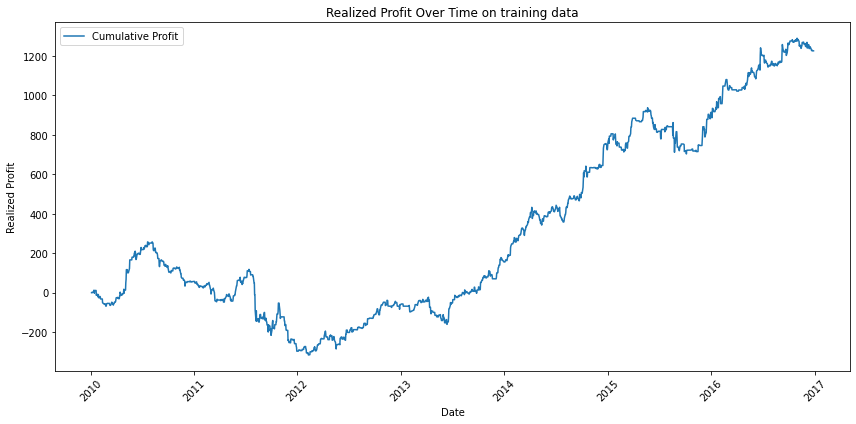

In [44]:
# Plotting the realized profit over time
plt.figure(figsize=(12, 6))
plt.plot(price_history["^GSPC"].index[:len(profit)], profit, label='Cumulative Profit')
plt.title('Realized Profit Over Time on training data')
plt.xlabel('Date')
plt.ylabel('Realized Profit')
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

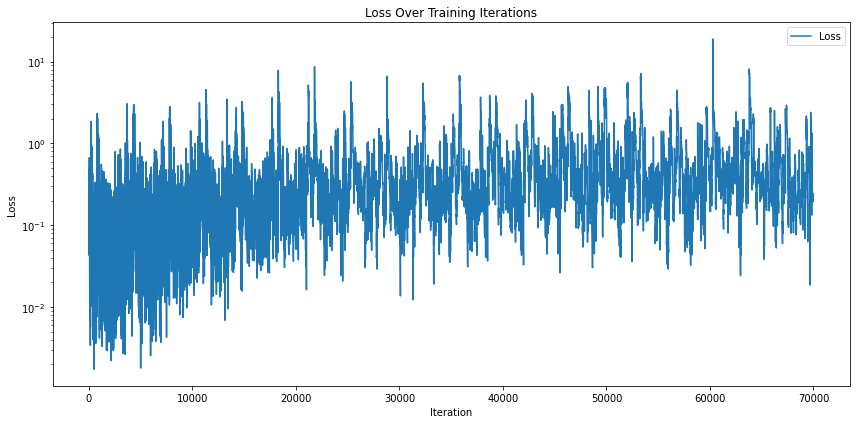

In [40]:
# Plotting the loss table
plt.figure(figsize=(12, 6))
plt.yscale('log')
plt.plot(Q.loss_table, label='Loss')
plt.title('Loss Over Training Iterations')
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.legend()
plt.tight_layout()
plt.show()


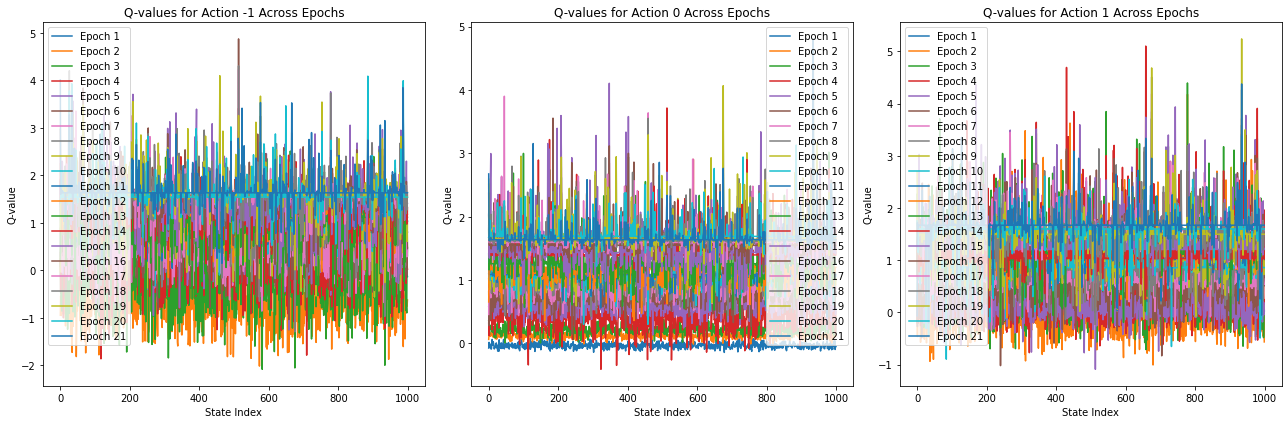

In [41]:
# Plot the Q-values for each action across epochs
plt.figure(figsize=(18, 6))

# Plot for action -1
plt.subplot(1, 3, 1)
for epoch, epoch_values in enumerate(q_values_over_epochs[-1]):
    plt.plot(range(len(epoch_values)), epoch_values, label=f'Epoch {epoch + 1}')
plt.title('Q-values for Action -1 Across Epochs')
plt.xlabel('State Index')
plt.ylabel('Q-value')
plt.legend()

# Plot for action 0
plt.subplot(1, 3, 2)
for epoch, epoch_values in enumerate(q_values_over_epochs[0]):
    plt.plot(range(len(epoch_values)), epoch_values, label=f'Epoch {epoch + 1}')
plt.title('Q-values for Action 0 Across Epochs')
plt.xlabel('State Index')
plt.ylabel('Q-value')
plt.legend()

# Plot for action 1
plt.subplot(1, 3, 3)
for epoch, epoch_values in enumerate(q_values_over_epochs[1]):
    plt.plot(range(len(epoch_values)), epoch_values, label=f'Epoch {epoch + 1}')
plt.title('Q-values for Action 1 Across Epochs')
plt.xlabel('State Index')
plt.ylabel('Q-value')
plt.legend()

plt.tight_layout()
plt.show()

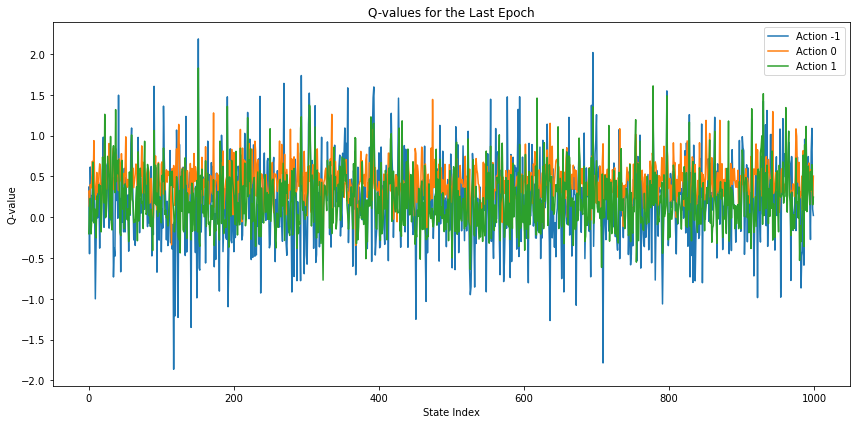

In [42]:
# Plot the Q-values for the last epoch
plt.figure(figsize=(12, 6))

epoch=3
for action in [-1, 0, 1]:
    plt.plot(range(len(q_values_over_epochs[action][epoch])), q_values_over_epochs[action][epoch], label=f'Action {action}')

plt.title('Q-values for the Last Epoch')
plt.xlabel('State Index')
plt.ylabel('Q-value')
plt.legend()
plt.tight_layout()
plt.show()

In [468]:
abs(np.array(q_values_over_epochs[1][-1])/np.array(q_values_over_epochs[0][-1]))>1

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,

In [386]:
indices = np.where((q_values_over_epochs[1][3]) > np.maximum(q_values_over_epochs[0][3], q_values_over_epochs[-1][3]))[0]
print(indices)

[]


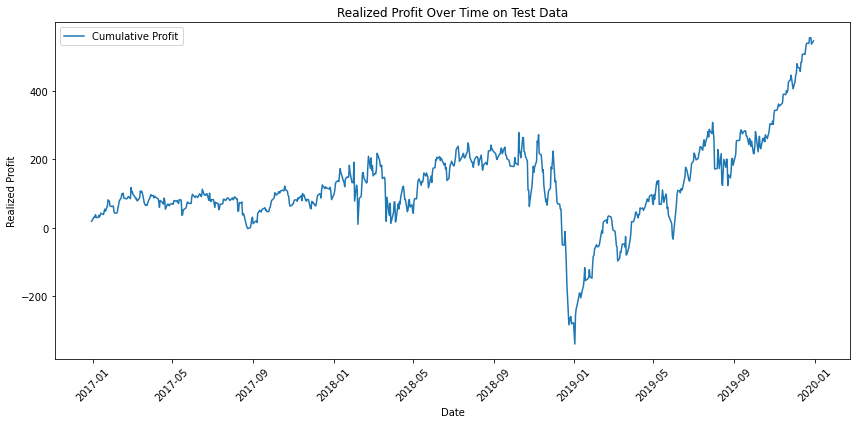

Total realized profit on test data: 545.5410189999989


In [45]:
# Initialize a new stock instance for testing
SP_test = stock("^GSPC")
test_profit = []

# Loop through the test dataset
for i in range(Ntrain, len(price_return) - 1):
    s = getState(SP_test, price_history["^GSPC"], i, window_size + 1)  # Get the state
    a = epsilon_greedy(Q, s, 0.0)  # Use the trained model (epsilon = 0 for greedy policy)
    date = price_history["^GSPC"].index[i]
    
    if a == 1:
        SP_test.buy(date, 1)  # Buy the share
        date2 = price_history["^GSPC"].index[i + 1]
        SP_test.sell(date2, 1)  # Sell immediately the next date
    elif a == -1:
        SP_test.sell(date, 1)  # Short the share
        date2 = price_history["^GSPC"].index[i + 1]
        SP_test.buy(date2, 1)  # Buy immediately the next date
    
    test_profit.append(SP_test.realized_profit)

# Close any open positions at the end of the test period
SP_test.close(price_history["^GSPC"].index[-1])

# Plot the realized profit over time on the test dataset
plt.figure(figsize=(12, 6))
plt.plot(price_history["^GSPC"].index[Ntrain:len(test_profit) + Ntrain], test_profit, label='Cumulative Profit')
plt.title('Realized Profit Over Time on Test Data')
plt.xlabel('Date')
plt.ylabel('Realized Profit')
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

print(f"Total realized profit on test data: {SP_test.realized_profit}")

## ARIMA model

/home/pranjal238/miniconda3/lib/python3.9/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


        Date  Log_Daily_Return
1 2010-01-05          0.003111
2 2010-01-06          0.000545
3 2010-01-07          0.003993
4 2010-01-08          0.002878
5 2010-01-11          0.001745


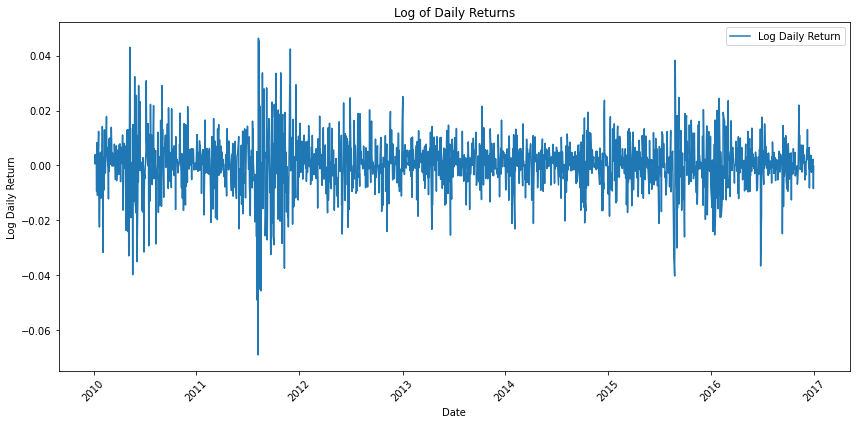

In [84]:
# Calculate the log of daily returns
log_daily_return = np.log(price_history["^GSPC"] / price_history["^GSPC"].shift(1))

# Create a DataFrame with the date and log of daily returns for the training data only
log_return_df = pd.DataFrame({
    'Date': price_history["^GSPC"].index[:Ntrain],
    'Log_Daily_Return': log_daily_return[:Ntrain]
}).reset_index(drop=True)

log_return_df.dropna(inplace=True)  # Drop NaN values resulting from the shift operation
print(log_return_df.head())

# Plot the log of daily returns
plt.figure(figsize=(12, 6))
plt.plot(log_return_df['Date'], log_return_df['Log_Daily_Return'], label='Log Daily Return')
plt.title('Log of Daily Returns')
plt.xlabel('Date')
plt.ylabel('Log Daily Return')
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()



## Test for stationarity of the udiff series

Time series are stationary if they do not contain trends or seasonal swings. The Dickey-Fuller test can be used to test for stationarity. 

In [ ]:
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller

# Perform Dickey-Fuller test
dftest = adfuller(log_return_df.Log_Daily_Return, autolag='AIC')
dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
for key, value in dftest[4].items():
    dfoutput['Critical Value ({0})'.format(key)] = value
    
dfoutput



Test Statistic                -9.553383e+00
p-value                        2.536530e-16
#Lags Used                     2.500000e+01
Number of Observations Used    1.734000e+03
Critical Value (1%)           -3.434127e+00
Critical Value (5%)           -2.863208e+00
Critical Value (10%)          -2.567658e+00
dtype: float64

## ACF and PACF Charts

Making autocorrelation and partial autocorrelation charts help us choose hyperparameters for the ARIMA model.

The ACF gives us a measure of how much each "y" value is correlated to the previous n "y" values prior.

The PACF is the partial correlation function gives us (a sample of) the amount of correlation between two "y" values separated by n lags excluding the impact of all the "y" values in between them. 

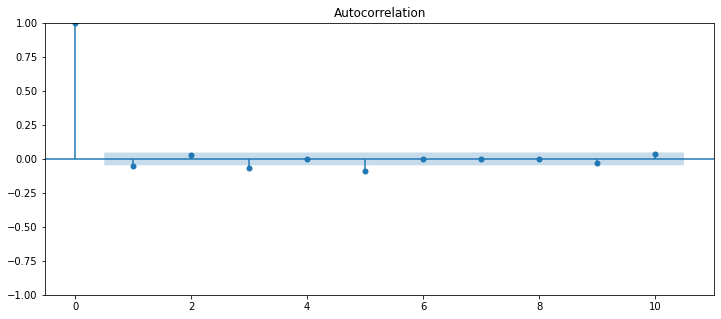

In [56]:
from statsmodels.graphics.tsaplots import plot_acf

# the autocorrelation chart provides just the correlation at increasing lags
fig, ax = plt.subplots(figsize=(12,5))
plot_acf(log_return_df['Log_Daily_Return'], lags=10, ax=ax)
plt.show()

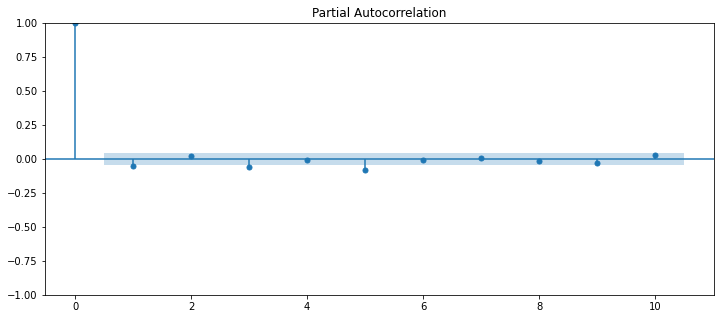

In [57]:
from statsmodels.graphics.tsaplots import plot_pacf

fig, ax = plt.subplots(figsize=(12,5))
plot_pacf(log_return_df['Log_Daily_Return'], lags=10, ax=ax)
plt.show()

The above chart shows that reading PACF gives us a lag "p" = 1 and reading ACF gives us a lag "q" of 1. Let's Use Statsmodel's ARMA with those parameters to build a model. The way to evaluate the model is to look at AIC - see if it reduces or increases. The lower the AIC (i.e. the more negative it is), the better the model.

In [58]:
from statsmodels.tsa.arima.model import ARIMA

# Notice that you have to use udiff - the differenced data rather than the original data.
ar1 = ARIMA(log_return_df['Log_Daily_Return'], order = (1, 0,1)).fit()
ar1.summary()

/home/pranjal238/.local/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/home/pranjal238/.local/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/home/pranjal238/.local/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:       Log_Daily_Return   No. Observations:                 1760
Model:                 ARIMA(1, 0, 1)   Log Likelihood                5643.198
Date:                Tue, 13 May 2025   AIC                         -11278.397
Time:                        18:39:14   BIC                         -11256.504
Sample:                             0   HQIC                        -11270.306
                               - 1760                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0004      0.000      1.662      0.097   -6.91e-05       0.001
ar.L1         -0.9649      0.014    -67.519      0.000      -0.993      -0.937
ma.L1          0.9185      0.018     51.001      0.000       0.883       0.954
sigma2      9.604e-05   2.02e-06     47.502      0.000    9.21e-05       0.000
===================================================================================
Ljung-Box (L1) (Q):                   0.03   Jarque-Bera (JB):              1028.63
Prob(Q):                              0.86   Prob(JB):                         0.00
Heteroskedasticity (H):               0.53   Skew:                            -0.42
Prob(H) (two-sided):                  0.00   Kurtosis:                         6.65
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

/home/pranjal238/miniconda3/lib/python3.9/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


2 0.0 0.001823356466429254 0.003993217689658429
3 0.0 0.0025459131561514714 0.002877583021532428
4 0.0 0.0019256649181227186 0.0017452316292985888
5 0.0 0.0024494729532519646 -0.00942544576897973
6 0.0 0.0004697514508116316 0.00829145632438373
7 0.0 0.0008849499279325431 0.0024234862235283476
8 0.0 3.624788460754227e-05 -0.010882126616956015
9 14.199951000000056 0.010534096844507717 0.012422151061536733
10 14.199951000000056 -0.00334327759867586 -0.010654386249253158
11 14.199951000000056 0.009535288778021844 -0.019126657637915045
12 14.199951000000056 -0.0011516256697351273 -0.022389778995586463
13 14.199951000000056 -0.008849867121009942 0.004587558568441081
14 14.199951000000056 0.00024095111148308545 -0.004212057527034682
15 14.199951000000056 -0.002877748504809115 0.004868282818539529
16 14.199951000000056 -0.001698433255648812 -0.011888125808015267
17 14.199951000000056 -0.002493263915162995 -0.009877798885372874
18 14.199951000000056 -0.003212275367375016 0.014165305282512393
19

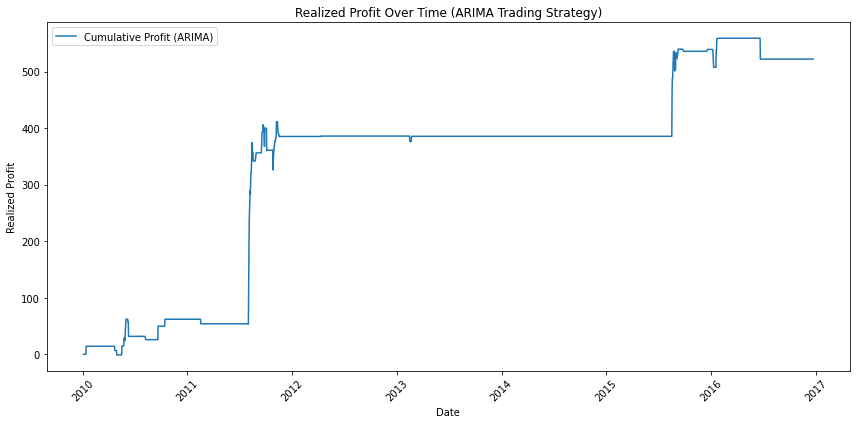

Total realized profit using ARIMA strategy: 521.990968999999


In [ ]:
# Define a threshold value for trading
threshold = 0.01  # Adjust this value as needed

# Initialize a stock instance for ARIMA-based trading
SP_arima = stock("^GSPC")
arima_profit = []

warnings.filterwarnings("ignore")
# Loop through the training dataset
predicted_returns = []  # List to store predicted returns
actual_returns = []  # List to store actual returns

for i in range(2, Ntrain - 1):
    # Predict the next day's return using the ARIMA model
    date = price_history["^GSPC"].index[i]
    ar1 = ARIMA(log_return_df.loc[(log_return_df['Date'] <= date) & 
                                  (log_return_df['Date'] > date - pd.Timedelta(days=window_size)), 
                                  'Log_Daily_Return'], order=(1, 0, 1)).fit()

    predicted_return = ar1.forecast(steps=1).values[0]
    predicted_returns.append(predicted_return)

    # Calculate the actual return for the next day
    if i + 1 < len(price_history["^GSPC"].index):
        actual_return = log_daily_return.iloc[i + 1]
        actual_returns.append(actual_return)

        if predicted_return > threshold:
            SP_arima.buy(date, 1)  # Buy the share
            date2 = price_history["^GSPC"].index[i + 1]
            SP_arima.sell(date2, 1)  # Sell the next day
        elif predicted_return < -threshold:
            SP_arima.sell(date, 1)  # Short the share
            date2 = price_history["^GSPC"].index[i + 1]
            SP_arima.buy(date2, 1)  # Buy the next day

    print(i, SP_arima.realized_profit, predicted_return, actual_return)
    arima_profit.append(SP_arima.realized_profit)

warnings.filterwarnings("default")

# Close any open positions at the end of the training period
SP_arima.close(price_history["^GSPC"].index[Ntrain - 1])

# Plot the realized profit over time for ARIMA-based trading
plt.figure(figsize=(12, 6))
plt.plot(price_history["^GSPC"].index[:len(arima_profit)], arima_profit, label='Cumulative Profit (ARIMA)')
plt.title('Realized Profit Over Time on training data (ARIMA)')
plt.xlabel('Date')
plt.ylabel('Realized Profit')
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

print(f"Total realized profit on training data using ARIMA: {SP_arima.realized_profit}")

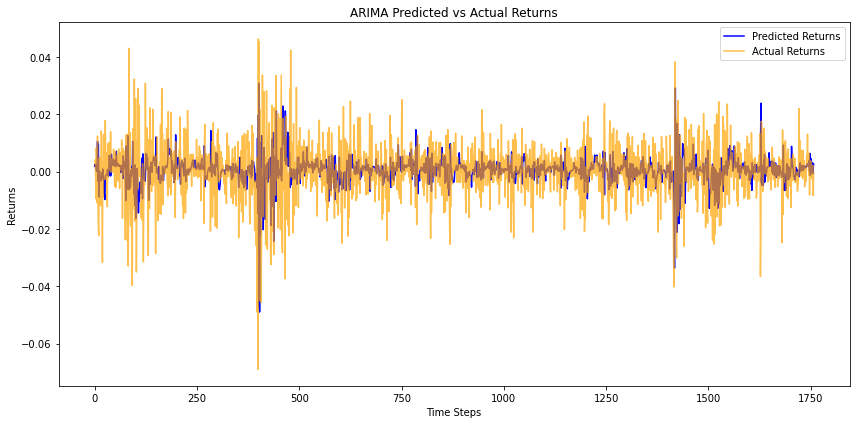

In [88]:
# Plot predicted returns and actual returns
plt.figure(figsize=(12, 6))
plt.plot(predicted_returns, label='Predicted Returns', color='blue')
plt.plot(actual_returns, label='Actual Returns', color='orange', alpha=0.7)
plt.title('ARIMA Predicted vs Actual Returns')
plt.xlabel('Time Steps')
plt.ylabel('Returns')
plt.legend()
plt.tight_layout()
plt.show()

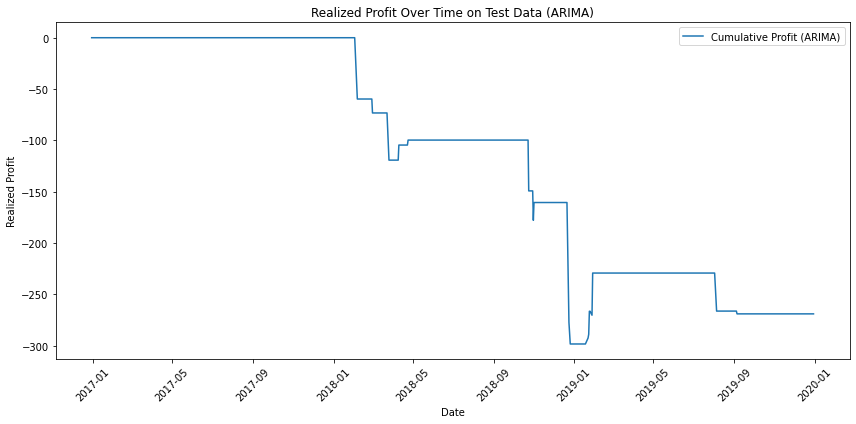

Total realized profit on test data using ARIMA: -268.86987499999987


In [92]:
# Initialize a stock instance for ARIMA-based trading on test data
SP_arima_test = stock("^GSPC")
arima_test_profit = []

# Loop through the test dataset
predicted_test_returns = []  # List to store predicted returns
actual_test_returns = []  # List to store actual returns

# Create a DataFrame with the date and log of daily returns for the test data only
log_return_df2 = pd.DataFrame({
    'Date': price_history["^GSPC"].index[:],
    'Log_Daily_Return': log_daily_return[:]
}).reset_index(drop=True)

log_return_df2.dropna(inplace=True)  # Drop NaN values resulting from the shift operation

warnings.filterwarnings("ignore")
for i in range(Ntrain, len(price_return) - 1):
    # Predict the next day's return using the ARIMA model
    date = price_history["^GSPC"].index[i]
    ar1 = ARIMA(log_return_df2.loc[(log_return_df2['Date'] <= date) & 
                                   (log_return_df2['Date'] > date - pd.Timedelta(days=window_size)), 
                                   'Log_Daily_Return'], order=(1, 0, 1)).fit()

    predicted_return = ar1.forecast(steps=1).values[0]
    predicted_test_returns.append(predicted_return)

    # Calculate the actual return for the next day
    if i + 1 < len(price_history["^GSPC"].index):
        actual_return = log_daily_return.iloc[i + 1]
        actual_test_returns.append(actual_return)

        if predicted_return > threshold:
            SP_arima_test.buy(date, 1)  # Buy the share
            date2 = price_history["^GSPC"].index[i + 1]
            SP_arima_test.sell(date2, 1)  # Sell the next day
        elif predicted_return < -threshold:
            SP_arima_test.sell(date, 1)  # Short the share
            date2 = price_history["^GSPC"].index[i + 1]
            SP_arima_test.buy(date2, 1)  # Buy the next day

    print(i, SP_arima_test.realized_profit)
    arima_test_profit.append(SP_arima_test.realized_profit)

warnings.filterwarnings("default")
# Close any open positions at the end of the test period
SP_arima_test.close(price_history["^GSPC"].index[-1])

# Plot the realized profit over time for ARIMA-based trading on test data
plt.figure(figsize=(12, 6))
plt.plot(price_history["^GSPC"].index[Ntrain:len(arima_test_profit) + Ntrain], arima_test_profit, label='Cumulative Profit (ARIMA)')
plt.title('Realized Profit Over Time on Test Data (ARIMA)')
plt.xlabel('Date')
plt.ylabel('Realized Profit')
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

print(f"Total realized profit on test data using ARIMA: {SP_arima_test.realized_profit}")

/home/pranjal238/miniconda3/lib/python3.9/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


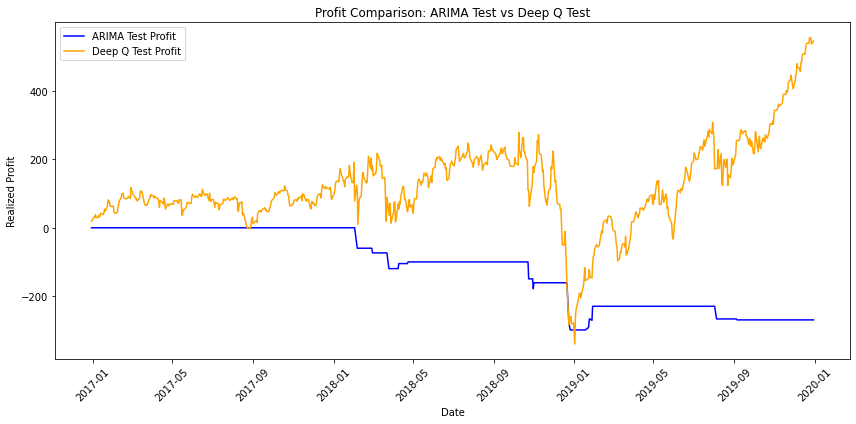

In [93]:
# Plot the realized profit for ARIMA test and Deep Q test side by side
plt.figure(figsize=(12, 6))

# Plot ARIMA test profit
plt.plot(price_history["^GSPC"].index[Ntrain:len(arima_test_profit) + Ntrain], arima_test_profit, label='ARIMA Test Profit', color='blue')

# Plot Deep Q test profit
plt.plot(price_history["^GSPC"].index[Ntrain:len(test_profit) + Ntrain], test_profit, label='Deep Q Test Profit', color='orange')

# Add titles and labels
plt.title('Profit Comparison: ARIMA Test vs Deep Q Test')
plt.xlabel('Date')
plt.ylabel('Realized Profit')
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()